# Sparse Grid Method for Continuous-Time Neoclassical Growth Model

This notebook solves the same continuous-time neoclassical growth model using a **sparse grid** collocation approach. We build a **hierarchical (nested) sparse grid** of collocation points in the state space and approximate the value function so that the HJB residual is zero at those points.

In 1D, a sparse grid reduces to a nested set of points (e.g. Clenshaw–Curtis); the same construction in higher dimensions would use many fewer points than a full tensor product. Here we use a **level-$\ell$ sparse grid** of points and **piecewise linear or polynomial interpolation** to represent $V(k)$.

## Model (same as other notebooks)

- **HJB**: $\rho V(k) = u(c) + V'(k)\, [f(k) - \delta k - c]$, with $c = (V'(k))^{-1/\gamma}$
- **Production**: $f(k) = k^\alpha$, **Utility**: $u(c) = c^{1-\gamma}/(1-\gamma)$

## Imports and parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.interpolate import interp1d

np.random.seed(42)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

rho = 0.05
alpha = 0.3
delta = 0.1
gamma = 2.0
k_min, k_max = 0.1, 10.0

print("Model: rho={}, alpha={}, delta={}, gamma={}".format(rho, alpha, delta, gamma))
print("Capital range: [{}, {}]".format(k_min, k_max))

Model: rho=0.05, alpha=0.3, delta=0.1, gamma=2.0
Capital range: [0.1, 10.0]


## Sparse grid construction (1D: nested Clenshaw–Curtis points)

For level $\ell$, define $n_\ell = 2^\ell + 1$ points (for $\ell=0$ we take 2 points at boundaries). We use **nested** Clenshaw–Curtis nodes: $x_i = \cos(\pi i / n)$ on $[-1,1]$, then map to $[k_{\min}, k_{\max}]$. The **sparse grid** in 1D is just the set of points at the chosen level; in higher dimensions we would take a Smolyak combination of levels.

In [2]:
def clenshaw_curtis_nodes_1d(level):
    """
    Nested Clenshaw-Curtis points at given level.
    Level 0: 2 points (boundaries); level ell: 2^ell + 1 points.
    """
    n = 2**level + 1 if level >= 1 else 2
    # x in [-1, 1]: cos(pi * i / (n-1)), i = 0..n-1
    i = np.arange(n)
    x = np.cos(np.pi * i / max(n - 1, 1))
    k = ((k_max - k_min) * (x + 1) / 2.0) + k_min
    return np.sort(k)

def sparse_grid_1d(level):
    """ In 1D, sparse grid = all Clenshaw-Curtis points at this level. """
    return clenshaw_curtis_nodes_1d(level)

level = 5
k_grid = sparse_grid_1d(level)
print("Sparse grid level =", level)
print("Number of points:", len(k_grid))
print("Points (k):", k_grid.round(4))

Sparse grid level = 5
Number of points: 33
Points (k): [ 0.1     0.1238  0.1951  0.3131  0.4768  0.6845  0.9342  1.2236  1.5498
  1.9098  2.2999  2.7166  3.1557  3.6131  4.0843  4.5648  5.05    5.5352
  6.0157  6.4869  6.9443  7.3834  7.8001  8.1902  8.5502  8.8764  9.1658
  9.4155  9.6232  9.7869  9.9049  9.9762 10.    ]


## Model primitives and HJB residual

We approximate $V(k)$ by **cubic spline interpolation** (or linear) over the grid values $V_i$ at $k_i$. So the unknowns are the vector $\mathbf{V} = (V_1,\ldots,V_n)$. The derivative $V'(k)$ is obtained by differentiating the interpolant. We then require the HJB residual to be zero at each grid point.

In [3]:
def production(k):
    return np.power(np.maximum(k, 1e-10), alpha)

def utility(c):
    c = np.maximum(c, 1e-10)
    if gamma == 1.0:
        return np.log(c)
    return (c ** (1 - gamma)) / (1 - gamma)

def consumption_from_foc(dV_dk):
    dV_dk = np.maximum(dV_dk, 1e-10)
    return np.power(dV_dk, -1.0 / gamma)

def hjb_residual_at_points(V_values, k_points, kind='cubic'):
    """
    Given V_values at k_points, build interpolant, compute V and V' at k_points,
    then HJB residual at each point. We need derivative: use spline derivative.
    """
    k_points = np.asarray(k_points)
    V_values = np.asarray(V_values)
    if kind == 'linear':
        interp = interp1d(k_points, V_values, kind='linear', fill_value='extrapolate')
        # For derivative at nodes, use finite difference
        dV = np.gradient(V_values, k_points)
    else:
        from scipy.interpolate import CubicSpline
        cs = CubicSpline(k_points, V_values)
        interp = cs
        dV = cs(k_points, 1)
    
    V_at = interp(k_points)
    c_at = consumption_from_foc(dV)
    f_k = production(k_points)
    dk_dt = f_k - delta * k_points - c_at
    u_c = utility(c_at)
    lhs = rho * V_at
    rhs = u_c + dV * dk_dt
    return lhs - rhs

def sparse_grid_system(V_flat, k_grid):
    """ Residual at each sparse grid point (for root solver). """
    return hjb_residual_at_points(V_flat, k_grid, kind='cubic')

## Solve: find V at sparse grid points

Unknowns: $V_i$ at each $k_i$. Initial guess: constant value (e.g. 1) or linear in $k$.

In [4]:
def solve_sparse_grid(level, tol=1e-9):
    k_grid = sparse_grid_1d(level)
    n = len(k_grid)
    # Initial guess: linear in k (rough guess for value function)
    V0 = 2.0 * np.log(k_grid + 0.5)  # or np.ones(n)
    
    sol = root(sparse_grid_system, V0, args=(k_grid,), method='hybr', tol=tol)
    if not sol.success:
        print("Warning:", sol.message)
    return sol.x, k_grid

V_grid, k_grid = solve_sparse_grid(level)
print("Solved. V at first/last grid points:", V_grid[0], V_grid[-1])

 improvement from the last ten iterations.
Solved. V at first/last grid points: -1.0216512475319814 4.702750514326955


## Interpolate on fine grid and plot

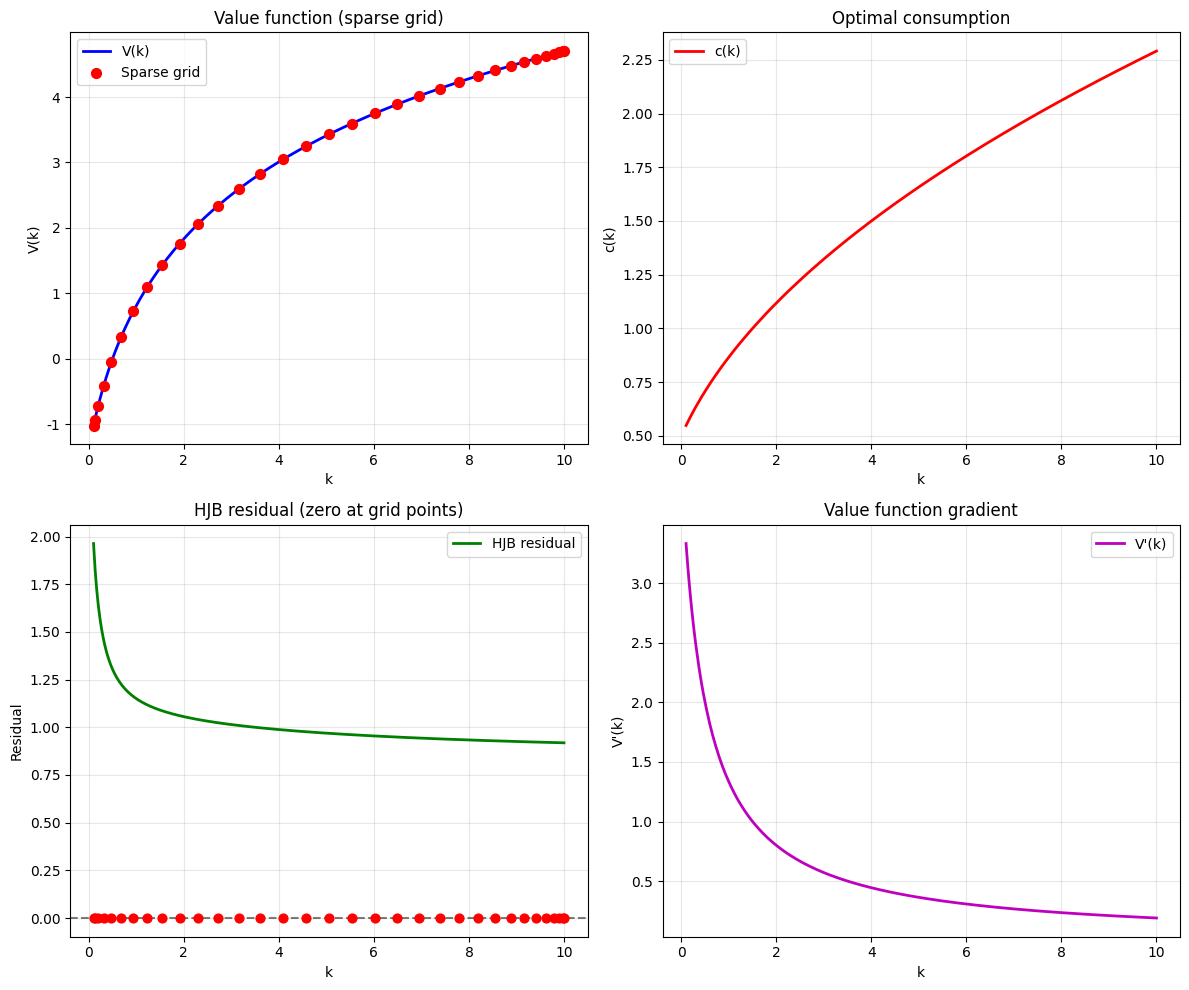

In [5]:
from scipy.interpolate import CubicSpline

def evaluate_on_fine(V_grid, k_grid, k_fine):
    cs = CubicSpline(k_grid, V_grid)
    V_fine = cs(k_fine)
    dV_fine = cs(k_fine, 1)
    c_fine = consumption_from_foc(dV_fine)
    f_f = production(k_fine)
    dk_f = f_f - delta * k_fine - c_fine
    res_fine = rho * V_fine - (utility(c_fine) + dV_fine * dk_f)
    return V_fine, dV_fine, c_fine, res_fine

k_fine = np.linspace(k_min, k_max, 300)
V_fine, dV_fine, c_fine, res_fine = evaluate_on_fine(V_grid, k_grid, k_fine)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(k_fine, V_fine, 'b-', lw=2, label='V(k)')
axes[0, 0].scatter(k_grid, V_grid, color='red', s=50, zorder=5, label='Sparse grid')
axes[0, 0].set_xlabel('k')
axes[0, 0].set_ylabel('V(k)')
axes[0, 0].set_title('Value function (sparse grid)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(k_fine, c_fine, 'r-', lw=2, label='c(k)')
axes[0, 1].set_xlabel('k')
axes[0, 1].set_ylabel('c(k)')
axes[0, 1].set_title('Optimal consumption')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(k_fine, res_fine, 'g-', lw=2, label='HJB residual')
axes[1, 0].axhline(0, color='k', ls='--', alpha=0.5)
axes[1, 0].scatter(k_grid, np.zeros(len(k_grid)), color='red', s=40, zorder=5)
axes[1, 0].set_xlabel('k')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('HJB residual (zero at grid points)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(k_fine, dV_fine, 'm-', lw=2, label="V'(k)")
axes[1, 1].set_xlabel('k')
axes[1, 1].set_ylabel("V'(k)")
axes[1, 1].set_title('Value function gradient')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Residual check

Residual at sparse grid points should be (near) zero.

In [6]:
res_at_grid = sparse_grid_system(V_grid, k_grid)
print("Max |residual| on fine grid:", np.max(np.abs(res_fine)))
print("Mean |residual| on fine grid:", np.mean(np.abs(res_fine)))
print("Max |residual| at sparse grid points:", np.max(np.abs(res_at_grid)))

Max |residual| on fine grid: 1.963076585765239
Mean |residual| on fine grid: 1.0133927398582223
Max |residual| at sparse grid points: 1.963076585765239
